In [1]:
# --- 1) Imports & Setup ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", rc={"figure.figsize": (7, 4)})

from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.dummy import DummyRegressor

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


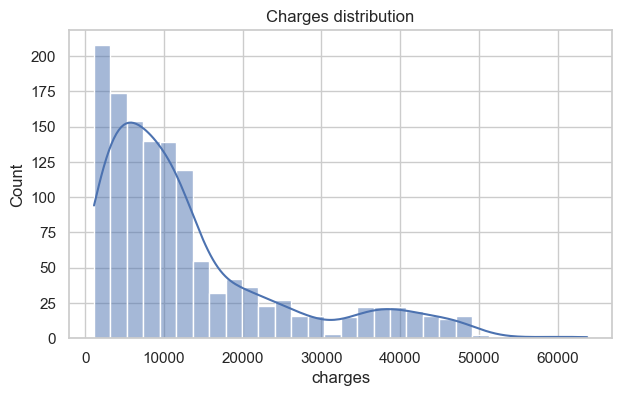

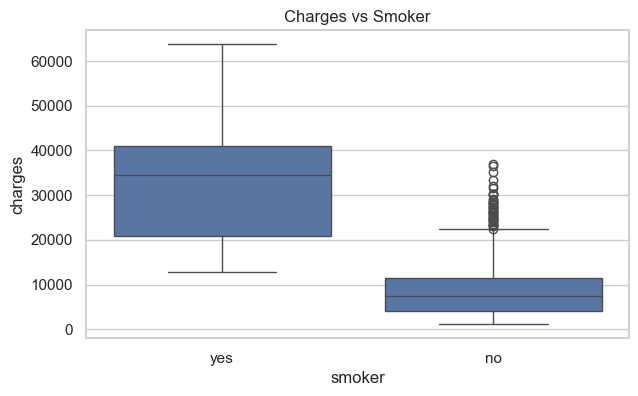

In [2]:
# --- 2) Load Data & Minimal EDA ---
df = pd.read_csv("../data/insurance.csv")

display(df.head())
print(df.info())
display(df.describe())

fig, ax = plt.subplots()
sns.histplot(df["charges"], kde=True, ax=ax)
ax.set_title("Charges distribution")
plt.show()


fig, ax = plt.subplots()
sns.boxplot(x="smoker", y="charges", data=df, ax=ax)
ax.set_title("Charges vs Smoker")
plt.show()

In [3]:
# --- 3) Split & Preprocessing
target = "charges"
X = df.drop(columns=[target])
y = df[target]

num_cols = ["age", "bmi", "children"]
cat_cols = ["sex", "smoker", "region"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

num_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

cat_transformer = OneHotEncoder(drop="first", handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_cols),
        ("cat", cat_transformer, cat_cols),
    ]
)


In [4]:
# --- 4) Baseline Model (DummyRegressor) ---
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

pipe_base = Pipeline(steps=[
    ("prep", preprocessor),
    ("model", DummyRegressor(strategy="mean"))
])

base_cv_scores = -cross_val_score(
    pipe_base, X_train, y_train, scoring="neg_root_mean_squared_error", cv=cv
)
print(f"[Baseline] CV_RMSE: {base_cv_scores.mean():.2f} ± {base_cv_scores.std():.2f}")

pipe_base.fit(X_train, y_train)
y_pred_base = pipe_base.predict(X_test)
rmse_base = np.sqrt(mean_squared_error(y_test, y_pred_base))
mae_base  = mean_absolute_error(y_test, y_pred_base)
r2_base   = r2_score(y_test, y_pred_base)
print(f"[Baseline] TEST -> RMSE: {rmse_base:.2f} | MAE: {mae_base:.2f} | R²: {r2_base:.3f}")


[Baseline] CV_RMSE: 12017.19 ± 361.87
[Baseline] TEST -> RMSE: 12465.61 | MAE: 9593.34 | R²: -0.001


In [5]:
# --- 5) Linear & Regularized Models (CV) ---
models = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(max_iter=20000, random_state=RANDOM_STATE),
    "ElasticNet": ElasticNet(max_iter=20000, random_state=RANDOM_STATE),
}

cv_results = {}
for name, est in models.items():
    pipe = Pipeline([("prep", preprocessor), ("model", est)])
    scores = -cross_val_score(pipe, X_train, y_train, scoring="neg_root_mean_squared_error", cv=cv)
    cv_results[name] = (scores.mean(), scores.std())
    print(f"[{name:9s}] CV_RMSE: {scores.mean():.2f} ± {scores.std():.2f}")

[Linear   ] CV_RMSE: 6123.35 ± 491.65
[Ridge    ] CV_RMSE: 6123.50 ± 491.76
[Lasso    ] CV_RMSE: 6123.27 ± 491.30
[ElasticNet] CV_RMSE: 9547.33 ± 322.46


In [8]:
# --- 6) Hyperparameter Tuning for ElasticNet ---
param_grid_en = {
    "model__alpha": np.logspace(-3, 2, 60),
    "model__l1_ratio": np.linspace(0.05, 0.95, 19),
}

pipe_en = Pipeline([
    ("prep", preprocessor),
    ("model", ElasticNet(max_iter=20000, random_state=RANDOM_STATE))
])

rs_en = RandomizedSearchCV(
    pipe_en,
    param_distributions=param_grid_en,
    n_iter=60,
    scoring="neg_root_mean_squared_error",
    cv=cv,
    random_state=RANDOM_STATE,
    n_jobs=1
)
rs_en.fit(X_train, y_train)

print("[ElasticNet] Best params:", rs_en.best_params_)
print(f"[ElasticNet] Best CV_RMSE: {-rs_en.best_score_:.2f}")

best_en = rs_en.best_estimator_
best_en.fit(X_train, y_train)


[ElasticNet] Best params: {'model__l1_ratio': np.float64(0.7), 'model__alpha': np.float64(0.001795714494371641)}
[ElasticNet] Best CV_RMSE: 6123.32


,steps,"[('prep', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [9]:
# --- 7) Test Evaluation (Best EN) ---
y_pred = best_en.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)
print(f"[ElasticNet-Best] TEST -> RMSE: {rmse:.2f} | MAE: {mae:.2f} | R²: {r2:.3f}")


[ElasticNet-Best] TEST -> RMSE: 5798.64 | MAE: 4188.10 | R²: 0.783


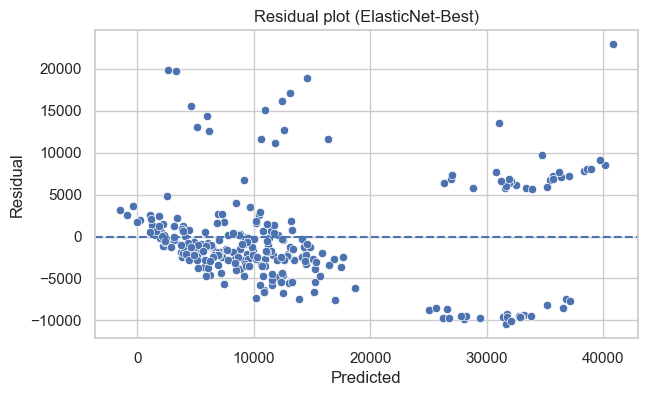

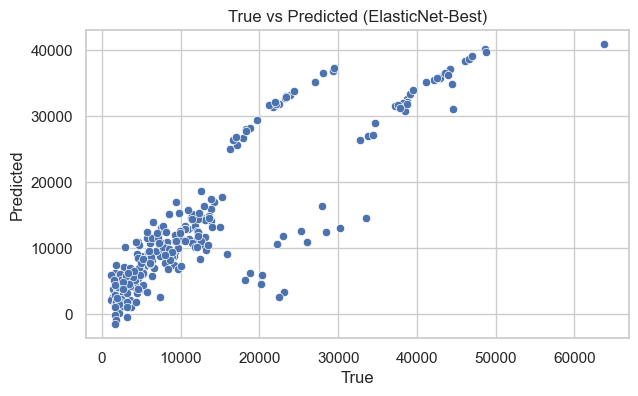

In [10]:
# --- 8) Diagnostics (Residuals & True vs Pred) ---
res = y_test - y_pred

fig, ax = plt.subplots()
sns.scatterplot(x=y_pred, y=res, ax=ax)
ax.axhline(0, ls="--")
ax.set_xlabel("Predicted")
ax.set_ylabel("Residual")
ax.set_title("Residual plot (ElasticNet-Best)")
plt.show()

fig, ax = plt.subplots()
sns.scatterplot(x=y_test, y=y_pred, ax=ax)
ax.set_xlabel("True")
ax.set_ylabel("Predicted")
ax.set_title("True vs Predicted (ElasticNet-Best)")
plt.show()


In [11]:
# --- 9) Summary (Markdown-friendly print) ---
print("\n=== Results Summary ===")
print(f"Baseline (mean)  -> TEST RMSE: {rmse_base:.2f} | MAE: {mae_base:.2f} | R²: {r2_base:.3f}")
for name, (m, s) in cv_results.items():
    print(f"{name:16s} CV_RMSE: {m:.2f} ± {s:.2f}")
print(f"ElasticNet (best)-> TEST RMSE: {rmse:.2f} | MAE: {mae:.2f} | R²: {r2:.3f}")


=== Results Summary ===
Baseline (mean)  -> TEST RMSE: 12465.61 | MAE: 9593.34 | R²: -0.001
Linear           CV_RMSE: 6123.35 ± 491.65
Ridge            CV_RMSE: 6123.50 ± 491.76
Lasso            CV_RMSE: 6123.27 ± 491.30
ElasticNet       CV_RMSE: 9547.33 ± 322.46
ElasticNet (best)-> TEST RMSE: 5798.64 | MAE: 4188.10 | R²: 0.783
